In [ ]:
!pip install deepxde

In [ ]:
import deepxde as dde
dde.backend.set_default_backend("pytorch")
from deepxde.backend import torch, backend_name
import torch

import numpy as np
import matplotlib.pyplot as plt

'''
"# DeepXDE will internally create tf.keras layers with these specs."
If there is any issue with torch.sin or other torch.###,
just replace it with tf.sin or tf.###.
'''

# # For reproducibility: fix all random seeds used by DeepXDE / TensorFlow backend
# dde.config.set_random_seed(1234)

In [ ]:
# ============================================================
# 1. Exact (analytical) solution of the Poisson problem
# ============================================================
def exact_solution(x):
    """
    Exact solution u(x) to the 1D Poisson problem we are solving.

    The solution is constructed as:
        u(x) = x + ∑_{i=1}^4 sin(i x) / i + sin(8x) / 8

    - x term       : linear part
    - sum_r1_term  : low-frequency sine components (i = 1,...,4), scaled by 1/i
    - sin(8x) / 8  : higher-frequency sine component

    Note:
        DeepXDE passes x as an array of shape (N, 1).
        We apply sin elementwise, just like NumPy normally does.
    """
    # Sum of sin(i x) / i for i = 1,...,4
    sum_r1_term = sum([np.sin(i * x) / i for i in range(1, 5)])
    # Add linear part x and the sin(8x)/8 part
    return x + sum_r1_term + np.sin(8 * x) / 8


# ============================================================
# 2. PDE residual: Poisson equation in 1D
# ============================================================
def poisson_residual(x, y):
    """
    PDE residual for the 1D Poisson-type problem.

    We consider an equation of the form:
        -u''(x) = f(x),

    where f(x) is chosen so that the exact solution is:
        u(x) = x + ∑_{i=1}^4 sin(i x) / i + sin(8x) / 8.

    DeepXDE calls this function with:
        x: (N, 1) tensor of coordinates
        y: (N, 1) tensor of network outputs u(x)

    Steps:
      1) Compute u_xx = ∂²u/∂x² using dde.grad.hessian
      2) Build the right-hand side f(x) as:
             f(x) = ∑_{i=1}^4 i * sin(i x) + 8 * sin(8x)
         (this is consistent with differentiating the exact solution twice)
      3) Return the residual:
             R(x) = -u_xx - f(x)
         DeepXDE will try to drive R(x) → 0 at all collocation points.
    """
    # Second derivative u_xx = d²u/dx²
    # y is the network output, x is the input coordinate
    u_xx = dde.grad.hessian(y, x)

    # Right-hand side f(x):
    #   derivative structure corresponds to known exact solution.
    #   x[:, 0:1] extracts the (N,1) column, keeping the shape.
    rhs_terms = [i * torch.sin(i * x[:, 0:1]) for i in range(1, 5)]
    rhs = sum(rhs_terms) + 8 * torch.sin(8 * x[:, 0:1])

    # Residual: -u_xx - f(x) = 0  →  -u_xx = f(x)
    return -u_xx - rhs


# ============================================================
# 3. Geometry (spatial domain)
# ============================================================
# 1D interval: x ∈ [0, π]
geom = dde.geometry.Interval(0, np.pi)


# ============================================================
# 4. DeepXDE PDE data object (no BCs explicitly listed!)
# ============================================================
data = dde.data.PDE(
    geom,              # Spatial domain
    poisson_residual,  # PDE residual function R(x) = 0
    [],                # No BC objects here; BCs will be enforced via output transform
    num_domain=64,     # Number of interior collocation points per training batch
    solution=exact_solution,  # Exact solution for error reporting and metrics
    num_test=400       # Number of test points for evaluation
)


# ============================================================
# 5. Neural network: FNN for u(x)
# ============================================================
# layer_size = [input_dim] + [hidden_dim,...] + [output_dim]
# Here:
#   input_dim  = 1 (x)
#   hidden_dim = 50 (3 hidden layers)
#   output_dim = 1 (scalar u(x))
layer_size = [1] + [50] * 3 + [1]
net = dde.nn.FNN(layer_size, "tanh", "Glorot uniform")


# ============================================================
# 6. Hard boundary conditions via output transform
# ============================================================
def hard_bc_output_transform(x, y):
    """
    Output transform that enforces Dirichlet boundary conditions exactly
    (a.k.a. 'hard' BCs).

    We want:
        u(0)   = 0
        u(π) = π

    The raw network output y(x) is unconstrained. We wrap it into:

        u(x) = x * (π - x) * y(x) + x

    Let's check the boundary values:

      - At x = 0:
            u(0) = 0 * (π - 0) * y(0) + 0 = 0

      - At x = π:
            u(π) = π * (π - π) * y(π) + π = π

    So, no matter what the network predicts (y), the transformed output u(x)
    *always* satisfies u(0) = 0 and u(π) = π.

    Inside the domain (0, π), the term x*(π - x) is nonzero, so the network
    still has full flexibility to shape the interior profile.

    DeepXDE's `apply_output_transform` mechanism:
      - Instead of returning y_raw(x) = net(x),
        the model will return  u(x) = hard_bc_output_transform(x, y_raw(x)).
      - This means the PDE residual is computed using u(x) that already
        satisfies the boundary conditions exactly.
    """
    # x[:, 0:1] ensures shape (N,1), matching y's shape.
    return x[:, 0:1] * (np.pi - x[:, 0:1]) * y + x[:, 0:1]


# Attach the output transform to the network.
# y_out is what DeepXDE will treat as the solution u(x).
'''
'net' is 'dde.nn.FNN' object 

net.apply_output_transform(***) 
=> DeepXDE internally stores this function and wraps the network's
forward pass so that: 

def forward(x):
    y_raw = core_net(x)                 # unconstrained output
    y_out = hard_bc_output_transform(x, y_raw)  # transformed output
    return y_out

# The PDE residual, loss, and prediction use 'y_out' (transformed output),
not the raw output 'y_raw'
'''
net.apply_output_transform(hard_bc_output_transform)


# ============================================================
# 7. Model, training, and evaluation
# ============================================================
# Build the PINN model: PDE data + neural network
model = dde.Model(data, net)

# Compile with Adam optimizer, small learning rate, and track L2 relative error
model.compile("adam", lr=1e-4, metrics=["l2 relative error"])

# Train for 3000 iterations
model.train(iterations=3000)

# Uniformly sample 200 points in the domain [0, π] (including endpoints)
x = geom.uniform_points(200, True)

# Network prediction at those points (after output transform)
y_pred = model.predict(x)

# Exact solution at those points
y_true = exact_solution(x)



In [ ]:

plt.figure(figsize=(8, 4))
plt.plot(x, y_true, label="Exact Solution", linewidth=2)
plt.plot(x, y_pred, "--", label="PINN Prediction", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN vs Analytical Solution")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




error = np.abs(y_true - y_pred)
plt.figure(figsize=(8, 4))
plt.plot(x, error, label="|u_true - u_pred|", color="darkred", linewidth=2)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.title("Point-wise Absolute Error")
plt.grid()
plt.tight_layout()
plt.show()

Epoch     0 | PDE loss = 4.6088e+01
Epoch   500 | PDE loss = 1.1931e+00
Epoch  1000 | PDE loss = 1.5194e-02
Epoch  1500 | PDE loss = 3.7222e-03
Epoch  2000 | PDE loss = 2.9639e-03
Epoch  2500 | PDE loss = 4.2510e-03
Epoch  3000 | PDE loss = 2.6204e-03
Epoch  3500 | PDE loss = 2.4297e-03
Epoch  4000 | PDE loss = 3.2180e-03
Epoch  4500 | PDE loss = 2.2265e-03
Relative L2 error: 1.1074e-03


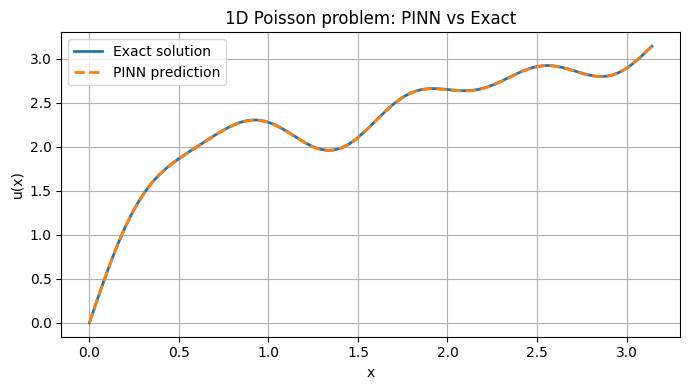

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ================================
# 1. Exact analytical solution
# ================================
def exact_solution_numpy(x_np):
    """
    Exact solution u(x) for comparison/evaluation.
    Input: x_np – numpy array of shape (N,) or (N,1)
    Output: u(x) – numpy array of same shape
    """
    x = x_np
    sum_r1_term = sum([np.sin(i * x) / i for i in range(1, 5)])  # sum_{i=1}^4 sin(i x)/i
    return x + sum_r1_term + np.sin(8 * x) / 8.0


# ================================
# 2. PINN model (PyTorch)
# ================================
class PoissonPINN(nn.Module):
    """
    Fully-connected neural network with
    a hard-encoded Dirichlet boundary condition via output transform:
    
        u(x) = x * (pi - x) * N(x) + x
    
    where N(x) is the unconstrained output of the network.
    This enforces:
        u(0) = 0 * (pi - 0) * N(0) + 0 = 0
        u(pi) = pi * (pi - pi) * N(pi) + pi = pi
    """
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
        self.layers = nn.ModuleList(layers)
        self.activation = nn.Tanh()

    def forward_raw(self, x):
        """
        Forward pass of the *unconstrained* network N(x).
        x: tensor of shape (N, 1)
        returns: N(x) of shape (N, 1)
        therefore, N(x) is the network output
        """
        h = x   # h: hidden representation
        # Apply tanh after all but the last layer
        for linear in self.layers[:-1]:
            h = self.activation(linear(h))
        # Last layer without activation
        out = self.layers[-1](h)
        return y

    
    def forward(self, x):
        """
        Forward pass that returns the *physical* solution u(x),
        which satisfies the boundary conditions exactly.
        
        u(x) = x * (pi - x) *  N(x) + x   ~> N(x) = y_raw(x)
        """
        N_x = self.forward_raw(x)  # N(x) ~ y_raw(x): unconstrained network output
        return x * (np.pi - x) * N_x + x


# ================================
# 3. Utility: compute u_xx with autograd
# ================================
def compute_u_xx(model, x):
    """
    Compute second derivative u_xx = d^2 u / dx^2 via autograd.

    Args:
        model: PoissonPINN instance
        x:     tensor of shape (N, 1) with requires_grad=True

    Returns:
        u_xx: tensor of shape (N, 1)
    """
    # Ensure we track gradient w.r.t x
    x.requires_grad_(True)

    # Forward pass to get u(x)
    u = model(x)

    # First derivative: u_x = du/dx
    u_x = torch.autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Second derivative: u_xx = d(u_x)/dx
    u_xx = torch.autograd.grad(
        u_x,
        x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True,
    )[0]

    return u_xx


# ================================
# 4. Right-hand side f(x)
# ================================
def f_rhs(x):
    """
    Right-hand side f(x) = sum_{i=1}^4 i * sin(i x) + 8 * sin(8x)
    for the Poisson equation -u''(x) = f(x).
    
    Input:
        x: tensor of shape (N, 1)
    Output:
        f(x): tensor of shape (N, 1)
    """
    rhs = torch.zeros_like(x)
    for i in range(1, 5):
        rhs = rhs + i * torch.sin(i * x)
    rhs = rhs + 8.0 * torch.sin(8.0 * x)
    return rhs


# ================================
# 5. Training setup
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Network architecture: [1, 50, 50, 50, 1]
layer_sizes = [1] + [50] * 3 + [1]
model = PoissonPINN(layer_sizes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of collocation points (interior points in (0, pi))
n_f = 1000

# Training loop
num_epochs = 5000

for epoch in range(num_epochs):
    # Sample collocation points x_f in (0, pi)
    x_f = torch.rand(n_f, 1, device=device) * np.pi  # uniform in [0, pi]
    x_f.requires_grad_(True)

    # Compute u_xx at these points
    u_xx = compute_u_xx(model, x_f)

    # Compute f(x)
    f_val = f_rhs(x_f)

    # PDE residual: R(x) = -u_xx - f(x)  (we want R ≈ 0)
    residual = -u_xx - f_val

    # Loss = MSE of residual
    loss_pde = torch.mean(residual**2)

    optimizer.zero_grad()
    loss_pde.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | PDE loss = {loss_pde.item():.4e}")


# ================================
# 6. Evaluation and comparison
# ================================
# Create a fine grid for plotting
x_test_np = np.linspace(0.0, np.pi, 200).reshape(-1, 1)
x_test = torch.tensor(x_test_np, dtype=torch.float32, device=device)

# Predict with the trained PINN
model.eval()
with torch.no_grad():
    u_pred = model(x_test).cpu().numpy()

# Exact solution on the same grid
u_true = exact_solution_numpy(x_test_np)

# L2 relative error
num = np.linalg.norm(u_pred - u_true)
den = np.linalg.norm(u_true)
rel_l2 = num / den
print(f"Relative L2 error: {rel_l2:.4e}")

# ================================
# 7. Plot results
# ================================
plt.figure(figsize=(7, 4))
plt.plot(x_test_np, u_true, label="Exact solution", linewidth=2)
plt.plot(x_test_np, u_pred, "--", label="PINN prediction", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("1D Poisson problem: PINN vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
